Diego Toribio <br>
Professor Fred Fontaine <br>
EID-378 Finance <br>
Problem Set II: Interest Rates and Bonds <br>

In [1]:
import numpy as np
import math
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.optimize import newton

## Section 1

The following code will perform backsubstitution: if $ A $ is a lower triangular matrix with nonzero elements on the diagonal, this will solve $ y = Ax $. Here, $ n $ is the length of the $ x,y $ vectors $( A $ is $ n \times n $):

```python
import numpy as np

x = np.zeros(n)

for i in range(0, n):
    tmp = y[i]
    for j in range(0, i):
        tmp -= x[j] * A[i, j]

    x[i] = tmp / A[i, i]
```

Feel free to modify it, convert it to a function, etc. It does not do error checking, and is based on the premise that $ A[i, j] = 0 $ for $ j > i $ (the code will still run if not, it just won’t solve $ y = Ax $ correctly), and that $ A[i, i] \neq 0 $.

Write Python code to do the following. Assume spot rates $ r $ and forward rates $ f $ are in continuous-compounding form, for simplicity. Given $ N $ bonds with prescribed coupon rates (coupons payable semi-annually), face value, current prices, and maturities exactly $ 0.5m $ years from today (i.e., coinciding with the coupon payments), with $ m = 1, 2, \dots, N $. You can have these values stored in whatever form you prefer—in separate `numpy.array` (vectors) or all together in a dataframe; note the above code, however, assumes $ y $ and $ A $ are `numpy` arrays.

(a) Solve for the discount factors $ Z(0, 0.5m) $ and from that term structure, i.e., $ r(0, 0.5m) $. Specifically, set up the matrix and use backsubstitution to solve for the term structure.

(b) From the term structure, compute the forward rates $ f(0, 0.5m, 0.5m + 0.5) $ for $ 0 \leq m \leq N - 1 $.

(c) Now apply your code to the following problem, assuming face value $\$1000$ for each bond:

| Bond Name | A      | B      | C      | D      |
|-----------|--------|--------|--------|--------|
| Maturity  | 0.5    | 1      | 1.5    | 2      |
| Bond Price| 985.86 | 974.70 | 967.99 | 966.82 |
| Coupon    | 2%     | 3%     | 4%     | 5%     |

(d) Plot the term structure (as a continuous curve), and display the forward rates.


#### Definitions

*Let’s start with a simple example. Imagine you buy a bond for $\$1,000$ with an annual coupon rate of $3\%$. That means each year you receive $\$30$ in interest, so after one year you’d have $\$1,030$.*


**Bond**  
A debt instrument that pays the holder a series of fixed cash flows (coupons) over time and returns the “face” (par) value at maturity.

**Zero‑Coupon Bond**  
A bond that pays **no periodic interest** (no coupons) and is issued at a **discount** to its face value, returning the full principal in a single lump sum at maturity.  
- For example, if a 5‑year zero‑coupon bond trades at $\$0.78$ per $\$1$ of face value, then the implied annual yield $r$ satisfies  
  $$
    0.78 \;=\;\frac{1}{(1 + r)^5},
  $$  
  which gives $r \approx 5.7\%$.


**Face Value (Par Value or Redemption)**  
The amount the bond issuer promises to pay back at maturity. All prices and rates in our example are quoted per $\$1$ of face value.

**Coupon Rate**  
The annual interest rate paid by the bond, expressed as a percentage of face value.  
- If the coupon rate is $5\%$, you receive $\$0.05$ per $\$1$ face each year.


**Discount Factors**  
A discount factor $Z(0,T)$ tells you the present value of $\$1$ to be received at time $T$. Under continuous compounding:  
$$
Z(0,T) \;=\; e^{-\,r\,T},
$$  
where $r$ is the continuously‑compounded spot rate.  
- For example, if $r=3\%$ and $T=1$, then $Z(0,1)=e^{-0.03}\approx0.97$. Receiving \$1 in one year is worth about \$0.97 today.


**Spot Rate**  
The yield (interest rate) on a zero‑coupon bond maturing at a specific future date $T$.  
- Denoted $r_1(0,T)$, it tells you how to discount a cash flow occurring at time $T$.


**Term Structure (Zero‑Coupon Yield Curve)**  
The term structure is the set of interest rates for zero‑coupon bonds of different maturities—e.g. the 6‑month rate, 1‑year rate, 1.5‑year rate, up to whatever horizon you choose.  
- For example, the 1‑year spot rate is $3\%$. If you also knew the 2‑year spot rate, 3‑year spot rate, etc., those rates together form the term structure.


**Calibrating the Term Structure**  
Calibrating means finding the discount factors (and thus spot rates) that make our _model_ prices match _market_ bond prices. We work backwards from observed bond prices and known cash flows to solve for the $Z(0,T)$ values.



**Setting Up the Calibration System**  
1. **Rows** – each row corresponds to one bond (with its market price).  
2. **Columns** – each column corresponds to a cash‑flow date $T$ (e.g. 0.5 yr, 1 yr, etc.).  
3. **Matrix entries** – the cash flow amount each bond pays at time $T$ (coupons and final principal).  
4. **Right‑hand side** – the vector of observed market prices.  

We solve the linear system  
$$
\mathbf{C}\,\mathbf{Z} \;=\;\mathbf{P}
$$  
for the discount vector $\mathbf{Z} = [Z(0,T_1), Z(0,T_2), \dots]^\top$.


### 1.1 ‑




#### Approach

In part (a), our goal is to calibrate the term structure by solving for the discount factors \(Z(0,0.5m)\) from observed bond prices. Once we have those, we derive the continuously‑compounded spot rates via  
$$
r(0,T) = -\frac{1}{T}\ln\bigl(Z(0,T)\bigr).
$$

In [ ]:
def solve_lower_triangular(A, y):
    # solve lower triangular system using back-substitution
    n = A.shape[0]
    x = np.zeros(n)
    for i in range(n):
        tmp = y[i]
        for j in range(i):
            tmp -= A[i, j] * x[j]
        x[i] = tmp / A[i, i]
    return x

def build_system(prices, coupons, face_value):
    # build system matrix and price vector for bond cash flows
    N = len(prices)
    A = np.zeros((N, N))
    y = np.array(prices)
    for i in range(N):
        for j in range(i + 1):
            # include coupon payment; add face value on final cash flow
            A[i, j] = coupons[i][j] + (face_value if j == i else 0)
    return A, y

# define bond data: prices, coupon cash flows, and face value
prices = [95.0, 92.0, 90.0]
coupons = [
    [2.0],
    [2.5, 2.5],
    [3.0, 3.0, 3.0]
]
face_value = 100.0

# build system for cash flows and bond prices
A, y_vec = build_system(prices, coupons, face_value)

# solve for discount factors using back-substitution
discount_factors = solve_lower_triangular(A, y_vec)

# compute maturities corresponding to each discount factor
maturities = np.array([0.5 * (i+1) for i in range(len(prices))])

# convert discount factors to continuously compounded spot rates
spot_rates = -np.log(discount_factors) / maturities

# prepare and output results table
rows = []
for i in range(len(prices)):
    bond_name = f"{i+1}"
    df = format(discount_factors[i], ".2g")
    sr = format(spot_rates[i], ".2g")
    rows.append([bond_name, df, sr])

headers = ["Bond", "Discount Factor", "Spot Rate"]
print(tabulate(rows, headers=headers, tablefmt="pretty"))

+------+-----------------+-----------+
| Bond | Discount Factor | Spot Rate |
+------+-----------------+-----------+
|  1   |      0.93       |   0.14    |
|  2   |      0.87       |   0.13    |
|  3   |      0.82       |   0.13    |
+------+-----------------+-----------+


### 1.2 - Forward Rates from Discount Factors

#### Context

After calibrating the term structure in part (a), we obtained discount factors that represent the current value of \$1 to be received at various future times. These discount factors provide a snapshot of the market’s interest rates for different maturities.

Forward rates build on this information—they indicate the implied future interest rate for a specific time period. In other words, while spot rates tell you the interest rate for a single cash flow at a future date, forward rates give you the rate for a period between two future dates.

#### Objective

The goal here is to compute the forward rates from the discount factors. Specifically, for the period between two consecutive cash flow times (for example, from 0.5 years to 1.0 years), we want to determine the continuously compounded forward rate that is consistent with the discount factors.

#### Approach

We use the relationship between discount factors and forward rates. Given the discount factors $Z(0,t)$ for times $t$ and $t+0.5$, the forward rate for the period $(t, t+0.5)$ is calculated as:

$$
f\bigl(0,\,t,\,t+0.5\bigr) \;=\; \frac{\ln Z(0,t) - \ln Z(0,t+0.5)}{0.5}.
$$

This formula works because when discount factors are expressed as $Z(0,t) = e^{-r(0,t)t}$, the difference in logarithms of the discount factors gives us the effective rate over the period.

In [ ]:
def compute_forward_rates(discount_factors, maturities):
    # compute continuously compounded forward rates from discount factors
    forward_rates = []
    # for first period, use spot rate
    forward_rates.append(-np.log(discount_factors[0]) / maturities[0])
    for i in range(1, len(discount_factors)):
        dt = maturities[i] - maturities[i - 1]
        # compute forward rate between consecutive maturities
        f_rate = (np.log(discount_factors[i - 1]) - np.log(discount_factors[i])) / dt
        forward_rates.append(f_rate)
    return np.array(forward_rates)

# example discount factors and maturities
discount_factors = np.array([0.97, 0.94, 0.91])
maturities = np.array([0.5, 1.0, 1.5])

# compute forward rates
forward_rates = compute_forward_rates(discount_factors, maturities)

# prepare and display results table
rows = []
for i in range(len(forward_rates)):
    period = f"period {i+1}" if i > 0 else "period 1 (spot rate)"
    fr = format(forward_rates[i], ".2g")
    rows.append([period, fr])

headers = ["Period", "Forward Rate (continuous compounding)"]
print(tabulate(rows, headers=headers, tablefmt="pretty"))

+----------------------+---------------------------------------+
|        Period        | Forward Rate (continuous compounding) |
+----------------------+---------------------------------------+
| period 1 (spot rate) |                 0.061                 |
|       period 2       |                 0.063                 |
|       period 3       |                 0.065                 |
+----------------------+---------------------------------------+


### 1.3 -

#### Context

In this part, we apply our calibrated model to a set of four bonds with the following characteristics:

| Bond Name | Maturity (years) | Bond Price | Annual Coupon |
|-----------|------------------|------------|---------------|
| A         | 0.5              | 985.86     | 2%            |
| B         | 1.0              | 974.70     | 3%            |
| C         | 1.5              | 967.99     | 4%            |
| D         | 2.0              | 966.82     | 5%            |

Each bond has a face value of $\$1000$. Since coupons are paid semiannually, a $2\%$ annual coupon translates to $1\%$ every six months (i.e., $\$10$ per period), and similarly for the other bonds.

For example, Bond A (with a 0.5-year maturity) pays a single coupon plus face value at 0.5 years:
$$
\text{CF at } 0.5 \text{ years} = 10 + 1000 = 1010.
$$
Its pricing equation is:
$$
985.86 = 1010 \times Z(0, 0.5).
$$
Bonds B, C, and D are treated similarly, forming a system of equations that is lower-triangular.

#### Objective

Our goal is to:
1. Solve for the discount factors $Z(0,0.5)$, $Z(0,1.0)$, $Z(0,1.5)$, and $Z(0,2.0)$ by setting up and solving a system of equations.
2. Compute the continuously compounded spot rates from these discount factors using:
   $$
   r(0,T) = -\frac{\ln\bigl(Z(0,T)\bigr)}{T}.
   $$


In [ ]:
# define bond data: prices, coupon rates, and face value
prices = np.array([985.86, 974.70, 967.99, 966.82])
coupon_annual = np.array([0.02, 0.03, 0.04, 0.05])
face_value = 1000
N = len(prices)

# build coupon payment matrix for semiannual coupon bonds
# Each entry coupons[i][j] is the semiannual coupon payment for bond i
coupons = np.zeros((N, N))
for i in range(N):
    c_i = face_value * (coupon_annual[i] / 2.0)
    for j in range(i + 1):
        coupons[i][j] = c_i

# use build_system to get the system matrix and price vector
A, y_vec = build_system(prices, coupons, face_value)

# solve system to obtain discount factors
Z = solve_lower_triangular(A, y_vec)

# define maturities for each discount factor (in years)
maturities = np.array([0.5 * (k + 1) for k in range(N)])

# compute continuously compounded spot rates
spot_rates = -np.log(Z) / maturities

# prepare and print results table
bonds = ["A", "B", "C", "D"]
rows = []
for i in range(N):
    df = format(Z[i], ".2g")
    sr = format(spot_rates[i] * 100, ".2g") + "%"
    rows.append([bonds[i], f"{maturities[i]:.1f}", f"{prices[i]:.2f}", df, sr])

headers = ["Bond", "Maturity (years)", "Price", "Discount Factor", "Spot Rate"]
print(tabulate(rows, headers=headers, tablefmt="pretty"))

+------+------------------+--------+-----------------+-----------+
| Bond | Maturity (years) | Price  | Discount Factor | Spot Rate |
+------+------------------+--------+-----------------+-----------+
|  A   |       0.5        | 985.86 |      0.98       |   4.8%    |
|  B   |       1.0        | 974.70 |      0.95       |   5.6%    |
|  C   |       1.5        | 967.99 |      0.91       |   6.2%    |
|  D   |       2.0        | 966.82 |      0.87       |   6.7%    |
+------+------------------+--------+-----------------+-----------+


### 1.4 -


#### Context

Previously, we calibrated the term structure by solving for discount factors from observed bond prices, and from these, we computed the continuously compounded spot rates and the forward rates. The term structure (spot rates) shows the effective interest rate for a single cash flow received at various maturities, while the forward rates represent the implied future short-term interest rates between consecutive periods.

#### Objective

Our goal here is to:
1. Plot the term structure—that is, the spot rates $r(0, 0.5m)$ as a continuous curve against their corresponding maturities.
2. Plot the forward rates $f(0, 0.5m, 0.5(m+1))$ as a function of the starting time of the forward period.

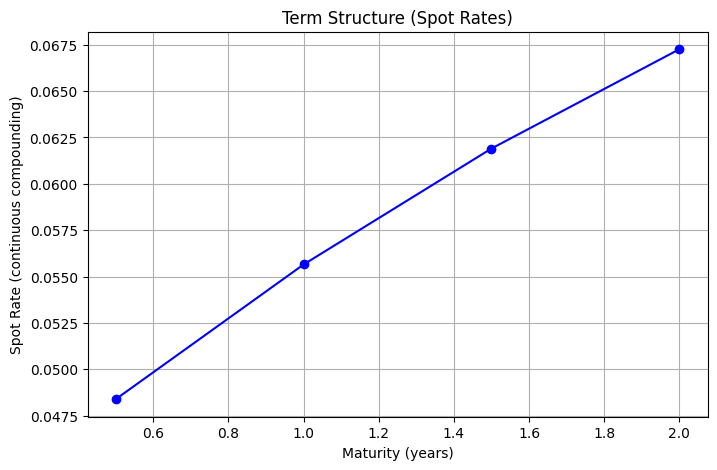

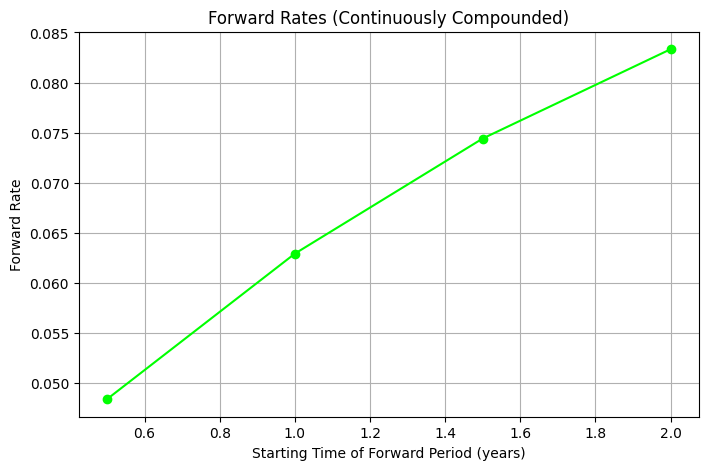

In [ ]:
# use discount factors from previous computation
Z_solved = Z
forward_rates = compute_forward_rates(Z_solved, maturities)

# set forward rate maturities (same as maturities)
forward_maturities = maturities

# plot term structure (spot rates)
plt.figure(figsize=(8, 5))
plt.plot(maturities, spot_rates, marker='o', linestyle='-', color='#0000FF')
plt.title("Term Structure (Spot Rates)")
plt.xlabel("Maturity (years)")
plt.ylabel("Spot Rate (continuous compounding)")
plt.grid(True)
plt.show()

# plot forward rates
plt.figure(figsize=(8, 5))
plt.plot(forward_maturities, forward_rates, marker='o', linestyle='-', color='#00FF00')
plt.title("Forward Rates (Continuously Compounded)")
plt.xlabel("Starting Time of Forward Period (years)")
plt.ylabel("Forward Rate")
plt.grid(True)
plt.show()

## Section 2

Refer to the Python code below. It will compute the YTM from information about a bond (face value, price, and coupon rate).

```python
## From Mastering Python in Finance (with typo corrections by FF)
import scipy.optimize as optimize

def bond_ytm(price, FaceVal, T, coup, freq=2, guess=0.05):
    freq = float(freq)
    periods = T * freq
    coupon = coup / 100. * FaceVal / freq
    dt = [(i + 1) / freq for i in range(int(periods))]
    ytm_func = lambda y: sum([coupon / (1 + y / freq)**(freq * t)
                              for t in dt]) + FaceVal / (1 + y / freq)**periods - price
    return optimize.newton(ytm_func, guess)
```

Write Python code that: given the term structure (annual) $ r_1(0,m) $, $ 1 \leq m \leq N $, and **annual** coupon rate (i.e., assume the coupons are paid annually) of a bond, will compute the price per $\$1$ face value and YTM of the bond.

Now take $ N = 10 $ and assume the Nelson-Siegel model with parameters $ \beta_0 = 0.02 $, $ \beta_1 = 0.02 $, $ \beta_2 = 0.20 $, $ \tau = 5 $:

$$
r_1(0,T) = \beta_0 + (\beta_1 + \beta_2)\frac{\tau_1}{T}\left(1 - e^{-T/\tau_1}\right) - \beta_2 e^{-T/\tau_1}
$$

Compute the price per $\$1$ face value and YTM for coupon rates $ 0\%, 1\%, \dots, 9\% $, and plot each curve.

<br>
<br>


#### Definitions

**Nelson–Siegel Model**  
A four‑parameter, smooth–curve formula used to represent the entire term structure with a single function:  
$$
r_1(0,T)
=\beta_0
+(\beta_1+\beta_2)\,\frac{\tau}{T}\bigl(1-e^{-T/\tau}\bigr)
-\beta_2\,e^{-T/\tau}.
$$  
- **β₀ (Level):** long‑term rate  
- **β₁ (Slope):** short‑term tilt  
- **β₂ (Curvature):** mid‑term hump  
- **τ (Decay):** controls hump location

**Discounting**  
The process of converting a future cash flow into today’s dollars using the appropriate spot rate:  
$$
\frac{\$1}{(1 + r_1(0,T))^T}.
$$

**Yield to Maturity (YTM)**  
The constant annual interest rate \(y\) that makes the present value of all coupon and redemption cash flows equal the bond’s current price.  

**Root‑Finding (Newton’s Method)**  
An iterative algorithm that solves for YTM by finding the root of  
$$
\text{PV of cash flows at }y \;-\;\text{price} \;=\;0.
$$
<br>

### 2.1 -



#### Approach

In this section, we want to price a bond and compute its Yield to Maturity (YTM) given:
- A set of annual spot rates for maturities $m = 1, 2, \dots, N$.
- A fixed, annual coupon payment (stated as a percentage of face value) paid once per year.
- A bond maturity of $N = 10$ years.

We will use the *Nelson–Siegel* model to **generate** these spot rates. Recall the Nelson–Siegel formula we are given:

$$
r_1(0,T) \;=\; \beta_0 \;+\; (\beta_1 + \beta_2)\,\frac{\tau_1}{T}\,\Bigl(1 - e^{-\,T/\tau_1}\Bigr)\;-\;\beta_2\,e^{-\,T/\tau_1},
$$

where:
- $\beta_0, \beta_1, \beta_2, \tau_1$ are parameters.  
- $T$ is the maturity in years.  
- $r_1(0,T)$ is the annualized zero rate (spot rate) for maturity $T$.  

Once we have each annual spot rate $ r_1(0,t) $ for $ t = 1,2,\dots,10 $, we price the bond (per \$1 face value) by summing the discounted value of each coupon plus redemption at maturity:

$$
\text{Price} = \sum_{t=1}^{10} \frac{\text{Coupon}}{(1 + r_1(0,t))^t}
\;+\;
\frac{1}{(1 + r_1(0,10))^{10}},
$$

where  
$$\text{Coupon} = (\text{annual coupon rate}) \times (1.0)$$

since face value = \$1.  
<br>

Finally, to find the *Yield to Maturity (YTM)* from the bond’s price, we will use a root-finding approach (Newton’s method) similar to the snippet provided in the problem statement.  

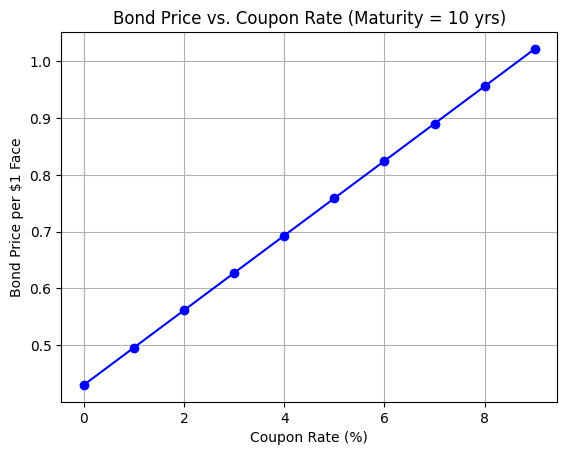

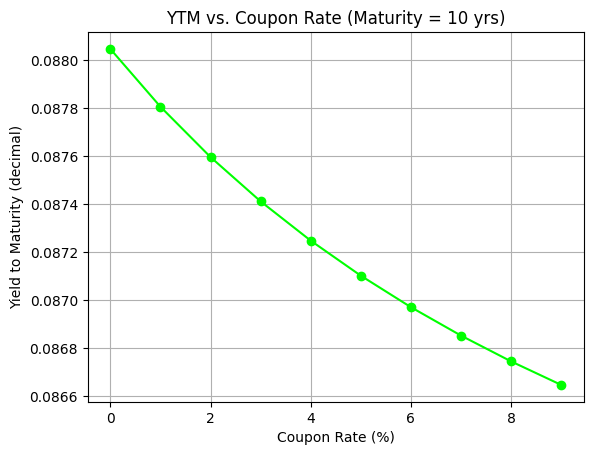

In [ ]:
#  Nelson-Siegel Setup
def nelson_siegel_rate(T, beta0, beta1, beta2, tau):
    """
    Returns the annualized spot rate r_1(0,T) using the Nelson-Siegel model:
    r_1(0,T) = beta0 + (beta1 + beta2)*((tau/T)*(1 - e^{-T/tau})) - beta2*e^{-T/tau}
    """
    return beta0 + (beta1 + beta2) * (tau / T) * (1.0 - np.exp(-T / tau)) - beta2 * np.exp(-T / tau)


#  bond Pricing given a set of annual spots
def bond_price_from_spot_rates(coupon_rate, spot_rates):
    """
    Compute the price per $1 face value of a bond with a specified
    annual coupon_rate (e.g. 0.05 for 5%).
    The bond has maturity len(spot_rates) years, paying one coupon/year.
    The discount for each coupon is 1/(1 + r(t))^t, where r(t) is spot_rates[t-1].
    """
    n = len(spot_rates)      # number of annual periods to maturity
    c = coupon_rate          # coupon in fraction form, e.g. 0.05
    pv = 0.0
    for t in range(1, n+1):
        # discount the coupon using the spot rate for that year
        pv += c / (1.0 + spot_rates[t-1])**t
    # add redemption of principal ($1) at maturity
    pv += 1.0 / (1.0 + spot_rates[n-1])**n
    return pv

# YTM calculation (annual compounding)
def bond_ytm(price, coupon_rate, maturity, guess=0.03):
    """
    Solve for yield y given:
      price = sum_{t=1..maturity} [coupon_rate/(1+y)^t] + [1/(1+y)^maturity].
    """
    def f(y):
        total_pv = 0.0
        for t in range(1, maturity+1):
            total_pv += coupon_rate / (1.0 + y)**t
        total_pv += 1.0 / (1.0 + y)**maturity
        return total_pv - price
    # Use Newton's method with an initial guess
    return newton(f, guess)


# Given parameters:
beta0 = 0.02  # (e.g. 2%)
beta1 = 0.02  # (additional shape factor)
beta2 = 0.20
tau   = 5.0

N = 10  # bond matures in 10 years

# Create the array of annual spot rates for T=1..N
spot_rates = np.zeros(N)
for t in range(1, N+1):
    spot_rates[t-1] = nelson_siegel_rate(t, beta0, beta1, beta2, tau)

#  compute bond prices & YTMs for coupon rates 0..9%
coupon_rates_percent = np.arange(0, 10)  # 0,1,2,...,9
prices = []
ytms   = []

for c_percent in coupon_rates_percent:
    c_decimal = c_percent / 100.0
    # Price from spot curve
    p = bond_price_from_spot_rates(c_decimal, spot_rates)
    prices.append(p)
    # YTM from that price
    y = bond_ytm(p, c_decimal, N)
    ytms.append(y)


# plot the results
plt.figure()
plt.plot(coupon_rates_percent, prices,
         marker='o',
         color='#0000FF')    # pure blue
plt.title("Bond Price vs. Coupon Rate (Maturity = 10 yrs)")
plt.xlabel("Coupon Rate (%)")
plt.ylabel("Bond Price per $1 Face")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(coupon_rates_percent, ytms,
         marker='o',
         color='#00FF00')    # pure green
plt.title("YTM vs. Coupon Rate (Maturity = 10 yrs)")
plt.xlabel("Coupon Rate (%)")
plt.ylabel("Yield to Maturity (decimal)")
plt.grid(True)
plt.show()


## Section 3

The Macauley duration $ D_{mac} $ assuming annual compounding can be expressed as:

$$
D_{mac} = 1 + \frac{1}{y_1} + \frac{T\,(y_1 - c) - (1 + y_1)}{c\left[(1+y_1)^T - 1\right] + y_1}
$$

where $ y_1 $ is the YTM, $ c $ is the coupon rate, and $ T $ is time-to-maturity in years. As a hint to its behavior, regardless of $ c $:

$$
\lim_{T \to \infty} D_{mac} = 1 + \frac{1}{y_1}
$$

(a) Write a function in Python to compute $ D_{mac} $ from these three parameters.

(b) As an example, set $ y_1 = 10\% $ and graph duration as a function of time to maturity, up to $ T = 100 $ years, for $ c = 2\% $ and $ 10\% $ (superimposed) with a horizontal line indicating the limiting value $ D_{mac}(T = \infty) $. [The reason for going out to 100 years is to show the convergence.] This should replicate a graph in the Brandimarte text.

(c) Generate several plots to help us visualize how $ D_{mac} $ varies with these parameters. What you do is up to you. We don’t want 1,000 plots, and the plots should have reasonable values (the above was an exception—don’t take $ T > 30 $ years normally). Do whatever you think is reasonable to illustrate how $ D_{mac} $ varies with these parameters.



#### Definitions

**Macaulay Duration** \($D_{\mathrm{mac}}$\)  
  The weighted average time (in years) until a bond’s cash flows (coupons + principal) are received, where weights are the present value of each cash flow as a fraction of the bond’s price.

**Yield to Maturity** \($y_1$\)  
  The single constant annual rate that equates the present value of all future cash flows to the bond’s current price.

**Coupon Rate** \($c$\)  
  The annual interest paid as a fraction of face value (e.g.\ 0.02 for 2%).

**Time to Maturity** \($T$\)  
  The remaining life of the bond in years.

**Limiting Duration**  
  As $T\to\infty$,  
  $$
    D_{\mathrm{mac}} \;\longrightarrow\; 1 + \frac{1}{y_1},
  $$  
  meaning very long‐dated bonds have duration approaching $1 + \frac{1}{y_1}$.
<br>
<br>

### 3.1 -


#### Approach

We encapsulate the Macaulay duration formula into a Python function and then confirm its accuracy on a simple 5‑year, 10 % YTM / 2 % coupon example.

- Implement the closed‑form expression inside `macaulay_duration_annual(y1, c, T)`.  
- Execute the function for \(y_1=0.10\), \(c=0.02\), \(T=5\) and verify the printed result matches the hand‑calculated duration.

In [ ]:
def macaulay_duration_annual(y1, c, T):
    """
    Computes the Macaulay duration assuming annual compounding.

    Parameters:
    -----------
    y1 : float
        The annual yield to maturity (e.g., 0.10 for 10%).
    c  : float
        The annual coupon rate (e.g., 0.02 for 2%).
    T  : float
        The time to maturity in years (could be non-integer, but typically integer).

    Returns:
    --------
    float
        The Macaulay duration D_mac for the given parameters.
    """

    numerator = T * (y1 - c) - (1 + y1)
    denominator = c * ((1 + y1)**T - 1) + y1

    D_mac = 1 + (1 / y1) + (numerator / denominator)
    return D_mac


example_duration = macaulay_duration_annual(0.10, 0.02, 5)
print("Example Macaulay Duration (y=10%, c=2%, T=5):", example_duration)

Example Macaulay Duration (y=10%, c=2%, T=5): 4.761707937424584


### 3.2 -

#### Approach

Here we fix the yield to maturity at $10\%$ and track how Macaulay duration evolves for maturities from 1 to 100 years under two coupon rates ($2\%$ and $10\%$). We compute the duration at each integer $T$, plot both series on the same axes, and draw a dashed horizontal line at the theoretical long‑run limit, $1 + \frac{1}{y_1} = 11$, so the convergence of both curves toward that asymptote is immediately clear.

- Evaluate $D_{\mathrm{mac}}$ for $T=1,2,\dots,100$ at $c=2\%$ and $c=10\%$.  
- Overlay the resulting curves and mark the horizontal limit line at 11.

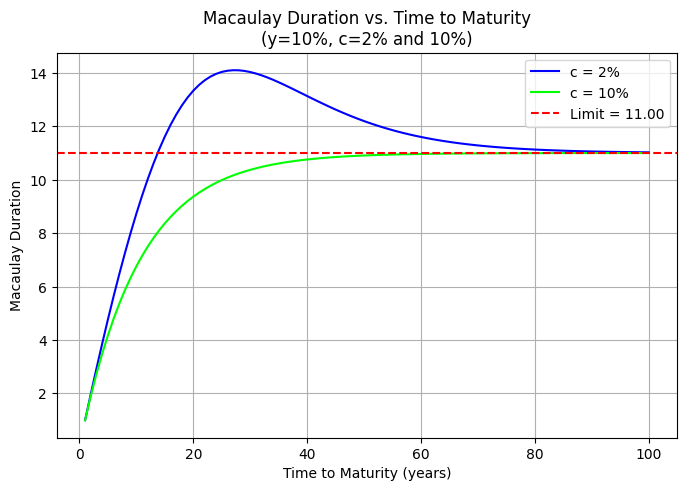

In [ ]:

y1_fixed = 0.10
c_values = [0.02, 0.10]  # 2% and 10%
T_max = 100
Ts = np.arange(1, T_max + 1)

# compute durations
durations_dict = {c: [macaulay_duration_annual(y1_fixed, c, T) for T in Ts] for c in c_values}

# limiting value
duration_limit = 1.0 + 1.0 / y1_fixed

# plot with specified hex colors
plt.figure(figsize=(8, 5))
colors = {0.02: '#0000FF', 0.10: '#00FF00'}
for c in c_values:
    plt.plot(Ts, durations_dict[c], label=f"c = {c*100:.0f}%", color=colors[c])

plt.axhline(duration_limit, color='red', linestyle='--', label=f"Limit = {duration_limit:.2f}")
plt.title("Macaulay Duration vs. Time to Maturity\n(y=10%, c=2% and 10%)")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Macaulay Duration")
plt.legend()
plt.grid(True)
plt.show()

### 3.3 -

#### Approach

We examine how Macaulay duration responds when we vary yield and coupon rate over a realistic maturity range. First, we compute $D_{\mathrm{mac}}$ for $T=1$ to 30 years at a fixed $5\%$ coupon while sweeping yields ($5\%$, $10\%$, $15\%$). Then we fix the yield at $10\%$ and vary the coupon rate ($2\%$, $5\%$, $10\%$) over the same maturity span, displaying both results in side‑by‑side subplots for direct comparison.

- Left plot: $c=5\%$, $y_1\in\{5\%,10\%,15\%\}$, $T=1\ldots30$.  
- Right plot: $y_1=10\%$, $c\in\{2\%,5\%,10\%\}$, $T=1\ldots30$.

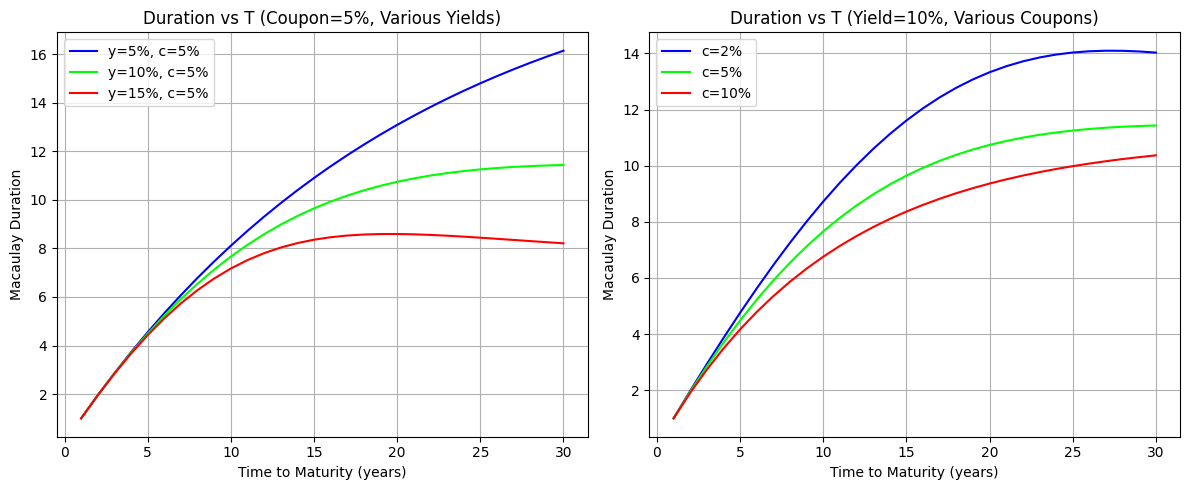

In [ ]:
# parameters
T_values = np.arange(1, 31)  # from 1 to 30 years
yields = [0.05, 0.10, 0.15]   # 5%, 10%, 15%
coupons = [0.02, 0.05, 0.10]  # 2%, 5%, 10%

# color mappings
yield_colors = {0.05: '#0000FF', 0.10: '#00FF00', 0.15: '#FF0000'}
coupon_colors = {0.02: '#0000FF', 0.05: '#00FF00', 0.10: '#FF0000'}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# Lleft subplot: fix coupon = 5%, vary yields
for y in yields:
    D_curve = [macaulay_duration_annual(y, 0.05, T) for T in T_values]
    axes[0].plot(T_values, D_curve, label=f"y={y*100:.0f}%, c=5%", color=yield_colors[y])

axes[0].set_title("Duration vs T (Coupon=5%, Various Yields)")
axes[0].set_xlabel("Time to Maturity (years)")
axes[0].set_ylabel("Macaulay Duration")
axes[0].legend()
axes[0].grid(True)

# right subplot: fix yield = 10%, vary coupons
y_fixed = 0.10
for c in coupons:
    D_curve = [macaulay_duration_annual(y_fixed, c, T) for T in T_values]
    axes[1].plot(T_values, D_curve, label=f"c={c*100:.0f}%", color=coupon_colors[c])

axes[1].set_title("Duration vs T (Yield=10%, Various Coupons)")
axes[1].set_xlabel("Time to Maturity (years)")
axes[1].set_ylabel("Macaulay Duration")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Section 4

Companies $ A $ and $ B $ have been offered the following rates per year on a $\$1$ million, 5-year investment:

|           | Fixed Rate | Floating Rate |
|-----------|------------|---------------|
| **A**     | 8.8%       | LIBOR         |
| **B**     | 8.0%       | LIBOR         |

(a) Company $ A $ prefers a fixed-rate loan, and company $ B $ prefers a floating-rate loan. Bank $ X $ has been engaged as an intermediary for a swap. The swap should be equally attractive to each company, and the bank should earn 0.2% annually. Design the swap.

(b) Suppose instead company $ A $ were offered a fixed rate of 8.0% and company $ B $ a rate of 8.8%. If you repeat your calculation, you will find a problem with it, and neither company would actually engage in the transaction. Explain in *words*, based on the discussion in the lecture: why doesn’t a swap make sense here?

#### Definitions

**Fixed‑Rate Loan**  
A loan on which the borrower pays a constant interest rate throughout the term.

**Floating‑Rate Loan**  
A loan on which the borrower pays a variable interest rate tied to a reference benchmark, reset periodically.

**LIBOR**  
The London Interbank Offered Rate, a widely used short‑term interbank benchmark for floating‑rate loans.

**Notional Amount**  
The reference principal (\$\!1,000,000 in this case) on which interest payments are calculated in a swap; the notional itself is never exchanged.

**Interest Rate Swap**  
A contractual agreement in which two parties exchange interest payments—one pays fixed, the other pays floating—on a shared notional amount to exploit relative cost advantages.

**Comparative Advantage**  
The relative borrowing‑cost benefit one party has over another in a given market (fixed or floating), which creates the “spread” that a swap can exploit.

**Fixed‑Rate Spread**  
The difference between the two firms’ fixed borrowing rates ($8.8\% – 8.0\% = 0.8\%$), representing the total potential gain available to share in the swap.

**Total Surplus**  
The difference between the two firms’ borrowing costs on the same side of the market (here, fixed), equal to $0.8\%$ in the example; this represents the maximum combined gain from the swap.

**Bank Fee**  
The portion of the total surplus ($0.2\%$ in our case) retained by the intermediary bank for arranging the swap.

**Net Gain**  
The remaining portion of the total surplus after deducting the bank fee ($0.6\%$ here), which is split equally between the two counterparties.

**Gain per Party**  
Each counterparty’s share of the net gain (half of the net gain, or $0.3\%$ here), reflecting their individual cost savings relative to direct borrowing.

**Net Exposure**  
The effective interest rate each counterparty pays (fixed or floating) after the swap, reflecting the adjusted cost of borrowing (e.g. A ends up at $8.5\%$ fixed; B at LIBOR – $0.3\%$).

With these in place, any reader unfamiliar with swaps will have clear reference definitions for both the mechanics (spread, surplus, fee) and the outcomes (gain, exposure).

### 4.1 – Swap Structure

Company B’s fixed borrowing cost (8.0 %) is 0.8 % below Company A’s (8.8 %), while both face LIBOR on floating debt. Bank X keeps 0.2 % of that spread, leaving 0.6 % to split equally (0.3 % each).

- **Net exposures:**  
  - A swaps into 8.5 % fixed (8.8 % – 0.3 %)  
  - B swaps into LIBOR – $0.3\%$  

Each firm thus achieves its preferred rate, and the bank earns its 0.2 % fee.

In [5]:
def compute_swap_summary(fixed_A, fixed_B, bank_fee=0.2):
    total_advantage = fixed_A - fixed_B
    net_to_share   = total_advantage - bank_fee
    gain_each      = net_to_share / 2

    # Net exposures after swap
    company_data = [
        {
            "Company":       "A",
            "Fixed Rate":    fixed_A - gain_each,       # 8.8 - 0.3 = 8.5
            "Floating Rate": "LIBOR",
            "Gain":          gain_each,
        },
        {
            "Company":       "B",
            "Fixed Rate":    "—",
            "Floating Rate": f"LIBOR – {gain_each:.1f}%",
            "Gain":          gain_each,
        },
    ]
    return company_data

company_data = compute_swap_summary(fixed_A=8.8, fixed_B=8.0, bank_fee=0.2)

# build and print table
table = []
for row in company_data:
    table.append([
        row["Company"],
        f"{row['Fixed Rate']:.1f}%" if isinstance(row["Fixed Rate"], float) else row["Fixed Rate"],
        row["Floating Rate"],
        f"{row['Gain']:.1f}%",
    ])

print("Table X: Net swap exposures & gains for Companies A and B.")
print(tabulate(table,
               headers=["Company", "Fixed Rate", "Floating Rate", "Gain"],
               tablefmt="pretty"))

Table X: Net swap exposures & gains for Companies A and B.
+---------+------------+---------------+------+
| Company | Fixed Rate | Floating Rate | Gain |
+---------+------------+---------------+------+
|    A    |    8.5%    |     LIBOR     | 0.3% |
|    B    |     —      | LIBOR – 0.3%  | 0.3% |
+---------+------------+---------------+------+


### 4.2 – No Gain

#### Approach


Reversing the fixed rates gives a spread of  

$$
8.0\% - 8.8\% = -0.8\%,
$$  

After the bank’s 0.2 % fee, the net is –1.0 %, which—split evenly—would leave each firm 0.5 % worse off.  With no positive surplus or comparative advantage to exploit, no swap can benefit either party.